In [1]:
import os
import struct
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import pydot
import pydotplus
import graphviz
import scipy
import scipy.stats as stats
from scipy.stats import norm
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


Centrare normale centrata sul valore medio dell'intervallo
Usare dev.std scelta arbitraria per ignorare

Valori in train e test potrebbero essere coincidenti

## Reproducibility

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creation of normal distribution of predecessors

In [3]:
size = 10000
normal = np.random.normal(loc= 0, scale=1, size= size)
np.ndarray.sort(normal)
max_val = max(normal)
width = 32

(-3.9224002516183423, 3.9262377064363267)

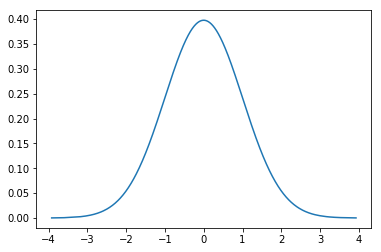

In [4]:
nmean = np.mean(normal)
nstd = np.std(normal)
pdf = stats.norm.pdf(normal, nmean, nstd)
plt.plot(normal, pdf)

np.min(normal), np.max(normal)

## Function to convert any number in binary

In [5]:
def float_to_bin(num):
    #return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
    string = format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
    return np.array([list(string)]).astype(int)

float_to_bin(1.512345)

array([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1]])

## Function to convert any binary in number

In [6]:
def bin_to_float(binary):
    return struct.unpack('!f', struct.pack('!I', int(binary, 2)))[0]

bin_to_float('00111111110000011001010010000101')

1.5123449563980103

## Creation of normal's ecdf

In [7]:
cumulative_normal = norm.cdf(normal, nmean, nstd)
cumulative_normal

array([4.67375282e-05, 6.63266170e-05, 1.19534550e-04, ...,
       9.99783561e-01, 9.99938922e-01, 9.99954801e-01])

## Conversion of normal to bins

In [8]:
bin_normal = (np.array([list(float_to_bin(i) for i in range(size))])).reshape(size, width)
bin_normal

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

## Creation of training + testing set

In [9]:
x_train, x_test, y_train, y_test = train_test_split(
    bin_normal, 
    cumulative_normal, 
    test_size=0.25, 
    random_state=42)

In [10]:
x_train.shape, y_train.shape

((7500, 32), (7500,))

In [11]:
x_test.shape, y_test.shape

((2500, 32), (2500,))

## Network metrics

In [12]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.figure(figsize=(80,40))

## Model-building function

In [13]:
from keras import metrics, optimizers

def build_model(neurons):
    """ Return keras network model """
    model = Sequential()
    model.add(Dense(int(neurons * 3), input_dim=neurons, name="Input_dense_layer", activation="sigmoid"))
    model.add(BatchNormalization())
    model.add(Dense(int(neurons * 2), name="Dense_layer_2", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(1, name="Output_dense_layer", activation="sigmoid"))
    model.compile(
        loss='mean_squared_error', 
        optimizer="adam", 
        metrics=['mean_absolute_error'])

    return model

## Model Construction

In [14]:
from keras.utils import plot_model

model = build_model(width)
model.summary()
plot_model(model, to_file="net_model_normal.png")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 96)                3168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)                384       
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 64)                6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
Output_dense_layer (Dense)   (None, 1)                 65        
Total params: 10,081
Trainable params: 9,761
Non-trainable params: 320
_________________________________________________________________


In [15]:
history = model.fit(
    x_train, 
    y_train,
    epochs=100,
    shuffle=True,
    batch_size=128,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(x_test, y_test)
)

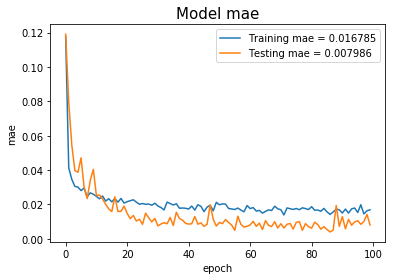

<Figure size 5760x2880 with 0 Axes>

In [16]:
%matplotlib inline
plot_history_graph(history, 'mean_absolute_error', 'mae')

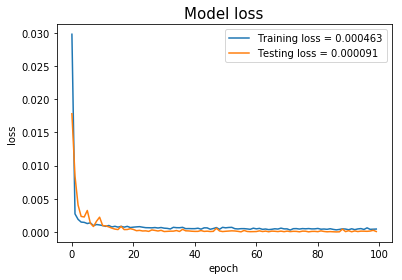

<Figure size 5760x2880 with 0 Axes>

In [17]:
plot_history_graph(history, 'loss', 'loss')

In [22]:
def prediction(num, model):
    bin = float_to_bin(num)
    print("Prediction on ", num, ":\t ", model.predict(bin))
    if(num < 0):
        return -1 * np.ceil(model.predict(bin) * size)
    else:
        return np.ceil(model.predict(bin) * size)
    #return np.floor(model.predict(bin) * size)

for number in range(int(np.floor(np.min(normal))), int(np.floor(np.max(normal)))):
    print("Predizione indice:\t\t\t", prediction(number, model))

Prediction on  -4 :	  [[0.00024609]]
Predizione indice:			 [[-3.]]
Prediction on  -3 :	  [[0.00017122]]
Predizione indice:			 [[-2.]]
Prediction on  -2 :	  [[0.00011881]]
Predizione indice:			 [[-2.]]
Prediction on  -1 :	  [[0.00216999]]
Predizione indice:			 [[-22.]]
Prediction on  0 :	  [[8.3223465e-05]]
Predizione indice:			 [[1.]]
Prediction on  1 :	  [[0.00465487]]
Predizione indice:			 [[47.]]
Prediction on  2 :	  [[0.00032635]]
Predizione indice:			 [[4.]]


In [19]:
np.min(normal)

-3.9224002516183423